In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [66]:
class MultyHandleBandit:
    def __init__(self, means, std_devs):
        self.means = means
        self.std_devs = std_devs
        self.k = len(means)  # Количество автоматов

    def pull_automat(self, id):
        if id < 0 or id >= self.k:
            raise Exception('Такого индекса нет')
        # np.random.seed(42)
        return np.random.normal(self.means[id], self.std_devs[id])

handle_bandit = MultyHandleBandit([1.25, 1.5, 1.75], [0.6, 0.5, 0.4])

In [75]:
class EpsGreedy:
    def __init__(self, epsilon, handle_bandit):
        self.count_k = len(handle_bandit.means)
        self.eps = epsilon
        self.handle_bandit = handle_bandit
        self.current_mark = {i: 0 for i in range(self.count_k)}
        self.count_operations = {i: 0 for i in range(self.count_k)}
        self.total_rewards = []

    def update_mark(self, id_automat, reward):
        self.count_operations[id_automat] += 1
        self.current_mark[id_automat] += (reward - self.current_mark[id_automat]) / self.count_operations[id_automat]

    def get_pull(self):
        if np.random.rand() < self.eps:  
            id_automat = np.random.randint(0, self.count_k)
        else: 
            id_automat = max(self.current_mark, key=self.current_mark.get)
        reward = self.handle_bandit.pull_automat(id_automat)
        self.update_mark(id_automat, reward)
        self.total_rewards.append(reward)

    def start(self, count):
        for _ in range(count):
            self.get_pull()

In [76]:
class Softmax:
    def __init__(self, temperature, handle_bandit):
        self.count_k = len(handle_bandit.means)
        self.temperature = temperature
        self.handle_bandit = handle_bandit
        self.current_mark = {i: 0 for i in range(self.count_k)}
        self.count_operations = {i: 0 for i in range(self.count_k)}
        self.total_rewards = []

    def softmax_prob(self):
        exp_values = np.exp(np.array(list(self.current_mark.values())) / self.temperature)
        return exp_values / exp_values.sum()

    def update_mark(self, id_automat, reward):
        self.count_operations[id_automat] += 1
        self.current_mark[id_automat] += (reward - self.current_mark[id_automat]) / self.count_operations[id_automat]

    def get_pull(self):
        probabilities = self.softmax_prob()
        id_automat = np.random.choice(range(self.count_k), p=probabilities)
        reward = self.handle_bandit.pull_automat(id_automat)
        self.update_mark(id_automat, reward)
        self.total_rewards.append(reward)

    def start(self, count):
        for _ in range(count):
            self.get_pull()

In [71]:
class UCB1:
    def __init__(self, handle_bandit):
        self.count_k = len(handle_bandit.means)
        self.handle_bandit = handle_bandit
        self.current_mark = {i: 0 for i in range(self.count_k)}
        self.count_operations = {i: 0 for i in range(self.count_k)}
        self.total_rewards = []
        self.total_pulls = 0

    def select_arm(self):
        for arm in range(self.count_k):
            if self.count_operations[arm] == 0:
                return arm
        ucb_values = {
            arm: self.current_mark[arm] + np.sqrt((2 * np.log(self.total_pulls)) / self.count_operations[arm])
            for arm in range(self.count_k)
        }
        return max(ucb_values, key=ucb_values.get)

    def update_mark(self, id_automat, reward):
        self.count_operations[id_automat] += 1
        self.total_pulls += 1
        self.current_mark[id_automat] += (reward - self.current_mark[id_automat]) / self.count_operations[id_automat]

    def get_pull(self):
        selected_arm = self.select_arm()
        reward = self.handle_bandit.pull_automat(selected_arm)
        self.update_mark(selected_arm, reward)
        self.total_rewards.append(reward)

    def start(self, count):
        for _ in range(count):
            self.get_pull()

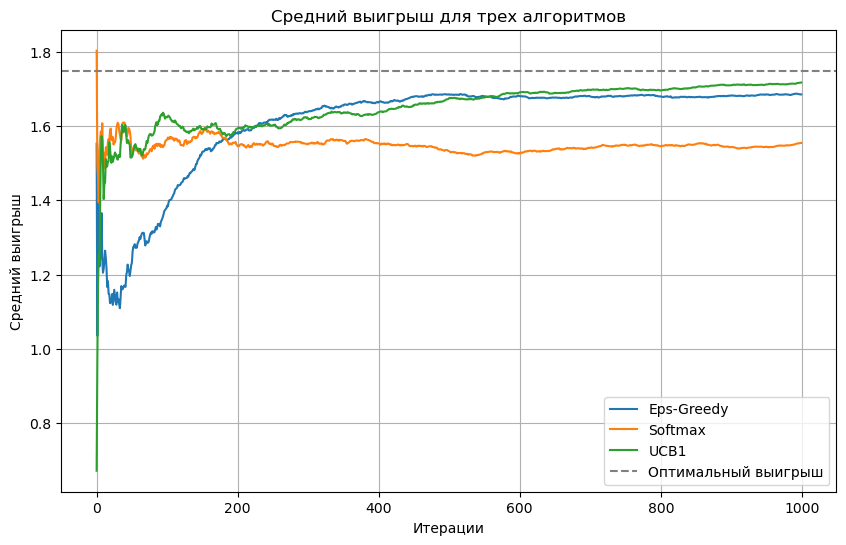

In [86]:
iterations = 1000

eps_greedy = EpsGreedy(0.1, handle_bandit)
eps_greedy.start(iterations)

softmax = Softmax(0.5, handle_bandit)
softmax.start(iterations)

ucb1 = UCB1(handle_bandit)
ucb1.start(iterations)

avg_rewards_eps = np.cumsum(eps_greedy.total_rewards) / np.arange(1, iterations + 1)
avg_rewards_softmax = np.cumsum(softmax.total_rewards) / np.arange(1, iterations + 1)
avg_rewards_ucb1 = np.cumsum(ucb1.total_rewards) / np.arange(1, iterations + 1)

plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_eps, label="Eps-Greedy")
plt.plot(avg_rewards_softmax, label="Softmax")
plt.plot(avg_rewards_ucb1, label="UCB1")
plt.axhline(max(handle_bandit.means), color='gray', linestyle='--', label='Оптимальный выигрыш')
plt.xlabel("Итерации")
plt.ylabel("Средний выигрыш")
plt.title("Средний выигрыш для трех алгоритмов")
plt.legend()
plt.grid()
plt.show()